# Data Exploration

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [2]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    # Ignore the ones which have this status somewhere before the last event. This makes the problem simpler!
    if len(df.index[df["status"] == "Der Empfu00E4nger hat die Sendung in der Filiale abgeholt."].tolist()) > 0:
        if df.index[df["status"] == "Der Empfu00E4nger hat die Sendung in der Filiale abgeholt."].tolist()[0] < len(df):
            return
    if len(df.index[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].tolist()) > 0:
        if df.index[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].tolist()[0] < len(df):
            return
    if len(df.index[df["status"].str.startswith("Die Sendung liegt in der") & df["status"].str.endswith("zur Abholung bereit.")].tolist()) > 0:
        if df.index[df["status"].str.startswith("Die Sendung liegt in der") & df["status"].str.endswith("zur Abholung bereit.")].tolist()[0] < len(df):
            return
    if len(df.index[df["status"] == "Die Sendung in Paketkasten-Anlage eingestellt"].tolist()) > 0:
        if df.index[df["status"] == "Die Sendung in Paketkasten-Anlage eingestellt"].tolist()[0] < len(df):
            return
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True)
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [3]:
def files_to_df(path='../data'):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [4]:
df = files_to_df(path='../../data')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


### Are there any missing values?

In [5]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [6]:
missing_value_df

,column_name,percent_missing
shipment_number,shipment_number,0.000000
crawltime,crawltime,0.000000
url,url,0.000000
datum,datum,0.000000
status,status,0.000000
is_final_event,is_final_event,0.000000
ort,ort,60.701754


Column "ort" has many missing values. We fill them with "Unbekannt"

In [7]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [8]:
df = fill_missing_values(df)

Check again if there are any missing values

In [9]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
is_final_event,is_final_event,0.0
ort,ort,0.0


### Data Stats

In [10]:
df.shape

(1995, 7)

Number of unique shipment numbers

In [11]:
len(df.shipment_number.unique())

495

### Investigate Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   shipment_number  1995 non-null   object             
 1   crawltime        1995 non-null   datetime64[ns, UTC]
 2   url              1995 non-null   object             
 3   datum            1995 non-null   datetime64[ns, UTC]
 4   status           1995 non-null   object             
 5   is_final_event   1995 non-null   float64            
 6   ort              1995 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 124.7+ KB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [13]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [14]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [15]:
df.head()

,shipment_number,crawltime,url,datum,status,is_final_event,ort,status_next,ort_next,datum_next
0,00340434154847512209,2020-02-11 01:38:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-11-15 16:59:00+00:00,Die Sendung wurde storniert.,1.0,Unbekannt,SuccessDelivery,SuccessDelivery,2020-04-14
0,00340434193824592131,2020-02-11 05:03:57+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2020-02-06 13:59:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,0.0,Unbekannt,Die Sendung wurde von DHL bearbeitet und wird ...,Bu00F6rnicke,2020-02-06 15:47:00+00:00
1,00340434193824592131,2020-02-11 05:03:57+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2020-02-06 15:47:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,0.0,Bu00F6rnicke,Die geringfu00FCgig beschu00E4digte Sendung wi...,Bu00F6rnicke,2020-02-06 15:50:00+00:00
2,00340434193824592131,2020-02-11 05:03:57+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2020-02-06 15:50:00+00:00,Die geringfu00FCgig beschu00E4digte Sendung wi...,0.0,Bu00F6rnicke,Die Sendung wird fu00FCr den Weitertransport v...,Staufenberg,2020-02-07 00:43:00+00:00
3,00340434193824592131,2020-02-11 05:03:57+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2020-02-07 00:43:00+00:00,Die Sendung wird fu00FCr den Weitertransport v...,0.0,Staufenberg,Die Sendung ist in der Region des Empfu00E4nge...,Staufenberg,2020-02-07 02:44:00+00:00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 0
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   shipment_number  1995 non-null   object             
 1   crawltime        1995 non-null   datetime64[ns, UTC]
 2   url              1995 non-null   object             
 3   datum            1995 non-null   datetime64[ns, UTC]
 4   status           1995 non-null   object             
 5   is_final_event   1995 non-null   float64            
 6   ort              1995 non-null   object             
 7   status_next      1995 non-null   object             
 8   ort_next         1995 non-null   object             
 9   datum_next       1995 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), object(7)
memory usage: 171.4+ KB


### Data Stats

In [17]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
is_final_event,is_final_event,0.0
ort,ort,0.0
status_next,status_next,0.0
ort_next,ort_next,0.0
datum_next,datum_next,0.0


In [18]:
df.shape

(1995, 10)

Number of unique shipment numbers

In [19]:
len(df.shipment_number.unique())

495

In [20]:
len(df.status.unique())

193

In [21]:
len(df.ort.unique())

84

### How many different final delivery states exist?

In [22]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

['Die Sendung wurde storniert.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Weimar+%28Lahn%29 Alte+Bahnhofstr. 15' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Weimar (Lahn) Alte Bahnhofstr. 15&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden."
 "Die Sendung wurde zur Abholung in die &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Stuttgartu0026strasse=Olgastr.u0026hausnummer=86u0026postleitzahl=70180u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Olgastr. 86 70180 Stuttgart&lt;/a&gt; gebracht."
 "Die Sendung liegt ab sofort in der Filiale &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Dachauu0026strasse=Anton-G%C3%BCnther-Str.+7u0026hausnummer=u0026postleitzahl=85221u0026l

### How many different initial delivery states exist?

In [23]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde storniert.'
 'Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.'
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.'
 'Die Sendung wurde vom Absender in der Filiale eingeliefert.'
 'Die Sendung wurde abgeholt.'
 'Die Sendung wird fu00FCr den Weitertransport vorbereitet.'
 'Die Sendung wurde am Wunschort abgeholt.']


### Distribution of all states

These are the most common states

In [24]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,275
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,274
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",248
Die Sendung wurde storniert.,244
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,177
Die Sendung wird fu00FCr den Weitertransport vorbereitet.,121
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,111
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,99
Die Sendung wurde direkt ab Paketzentrum dem Geschu00E4ftskunden zugestellt.,49
Die Sendung wurde ausgeliefert.,31


These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [25]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Stuttgart Senefelderstra%C3%9Fe 49' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Stuttgart Senefelderstrau00DFe 49&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Mainhausen Erwin-Grimm-Ring 1' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Mainhausen Erwin-Grimm-Ring 1&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Die Sendung liegt ab sofort in der Filiale &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Hamburgu0026strasse=Kiebitzstr.+21u0026hausnummer=u0026postleitzahl=22089u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Kiebitzstr. 21 22089 Hamburg&lt;/a&gt; zur Abholung bereit.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Weimar+%28Lahn%29 Alte+Bahnhofstr. 15' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Weimar (Lahn) Alte Bahnhofstr. 15&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Die Sendung befindet sich auf dem Weg zum Empfu00E4nger.,1
Die Sendung liegt ab sofort in der Filiale &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Landshutu0026strasse=Dreifaltigkeitsplatz+177u0026hausnummer=u0026postleitzahl=84028u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Dreifaltigkeitsplatz 177 84028 Landshut&lt;/a&gt; zur Abholung bereit.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Alzey Antoniterstr. 46' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Alzey Antoniterstr. 46&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Die Zustellung am gewu00FCnschten Liefertag 08.02.2020 wurde gewu00E4hlt.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Bad+Driburg Lange+Str. 124' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Bad Driburg Lange Str. 124&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Die Sendung wurde zur Abholung in die &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Berlinu0026strasse=Brunnenstr.u0026hausnummer=105-1u0026postleitzahl=13355u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Brunnenstr. 105-1 13355 Berlin&lt;/a&gt; gebracht.,1


In [26]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 


df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 

In [27]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,275
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,274
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",248
Die Sendung wurde storniert.,244
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,177
Die Sendung wird fu00FCr den Weitertransport vorbereitet.,121
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,111
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,99
Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,57
Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,50


In [28]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
Die Sendung wird zum Weitertransport vorbereitet.,1
Aufgrund einer Beschu00E4digung der Umverpackung wurde die Sendung neu verpackt.,1
Der gewu00FCnschte Liefertag wurde storniert oder kann aus betrieblichen Gru00FCnden leider nicht beru00FCcksichtigt werden.,1
Der Inhalt der Sendung wurde beschu00E4digt. Der DHL Kundenservice wird den Absender kontaktieren.,1
Die Sendung wurde leider beschu00E4digt und muss neu verpackt werden. Wir informieren Sie hier u00FCber den nu00E4chsten Schritt.,1
Die Sendung wurde aus der Packstation entnommen.,1
Die Zustellvorgaben des Versenders konnten nicht erfu00FCllt werden.,1
Die beschu00E4digte Sendung wird an die Nachverpackungsstelle weitergeleitet.,1
Die Sendung befindet sich auf dem Weg zum Empfu00E4nger.,1
Die geringfu00FCgig beschu00E4digte Sendung wurde nachverpackt und wird jetzt zum Empfu00E4nger transportiert,1


In [29]:
len(df["status"].unique())

51

In [30]:
len(df["status_next"].unique())

77

### Distribution of the locations

In [31]:
len(df["ort"].unique())

84

In [32]:
pd.DataFrame(df["ort"].value_counts()).head(20)

,ort
Unbekannt,1211
Ru00FCdersdorf,125
Bu00F6rnicke,99
Hamburg,96
Neumu00FCnster,36
Dorsten,30
Ku00F6ngen,22
Lahr,20
Krefeld,20
Ku00F6ln,19


In [33]:
pd.DataFrame(df["ort"].value_counts()).tail(20)

,ort
Heilbronn MechZB,1
Mannheim Nord MechZB,1
Leipzig MechZB,1
Osnabru00FCck MechZB,1
Nohra,1
Erfurt MechZB,1
Kitzingen,1
Moers MechZB,1
Berlin-Zentrum MechZB,1
Kiel,1


Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [34]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [35]:
df.head()

,shipment_number,datum,status,is_final_event,ort,status_next,ort_next,datum_next
0,00340434154847512209,2019-11-15 16:59:00+00:00,Die Sendung wurde storniert.,1.0,Unbekannt,SuccessDelivery,SuccessDelivery,2020-04-14
0,00340434193824592131,2020-02-06 13:59:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,0.0,Unbekannt,Die Sendung wurde von DHL bearbeitet und wird ...,Bu00F6rnicke,2020-02-06 15:47:00+00:00
1,00340434193824592131,2020-02-06 15:47:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,0.0,Bu00F6rnicke,Die geringfu00FCgig beschu00E4digte Sendung wi...,Bu00F6rnicke,2020-02-06 15:50:00+00:00
2,00340434193824592131,2020-02-06 15:50:00+00:00,Die geringfu00FCgig beschu00E4digte Sendung wi...,0.0,Bu00F6rnicke,Die Sendung wird fu00FCr den Weitertransport v...,Staufenberg,2020-02-07 00:43:00+00:00
3,00340434193824592131,2020-02-07 00:43:00+00:00,Die Sendung wird fu00FCr den Weitertransport v...,0.0,Staufenberg,Die Sendung ist in der Region des Empfu00E4nge...,Staufenberg,2020-02-07 02:44:00+00:00


### Time diff between events

In [36]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

In [37]:
df.head()

,shipment_number,datum,status,is_final_event,ort,status_next,ort_next,datum_next,datum_diff
0,00340434154847512209,2019-11-15 16:59:00+00:00,Die Sendung wurde storniert.,1.0,Unbekannt,SuccessDelivery,SuccessDelivery,2020-04-14 00:00:00+00:00,150 days 07:01:00
0,00340434193824592131,2020-02-06 13:59:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,0.0,Unbekannt,Die Sendung wurde von DHL bearbeitet und wird ...,Bu00F6rnicke,2020-02-06 15:47:00+00:00,0 days 01:48:00
1,00340434193824592131,2020-02-06 15:47:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,0.0,Bu00F6rnicke,Die geringfu00FCgig beschu00E4digte Sendung wi...,Bu00F6rnicke,2020-02-06 15:50:00+00:00,0 days 00:03:00
2,00340434193824592131,2020-02-06 15:50:00+00:00,Die geringfu00FCgig beschu00E4digte Sendung wi...,0.0,Bu00F6rnicke,Die Sendung wird fu00FCr den Weitertransport v...,Staufenberg,2020-02-07 00:43:00+00:00,0 days 08:53:00
3,00340434193824592131,2020-02-07 00:43:00+00:00,Die Sendung wird fu00FCr den Weitertransport v...,0.0,Staufenberg,Die Sendung ist in der Region des Empfu00E4nge...,Staufenberg,2020-02-07 02:44:00+00:00,0 days 02:01:00


### Define the problem as a regression problem

In [38]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

This means now that we want to predict the time between two events. The column "datum_diff_h" tells us the time diff betwen the two events in hours

##### First we only use two features. So the question is, given status and ort of an event, can we predict, when the next event will happen?

In [39]:
df_temp = df[df["is_final_event"] == 0]
X = df_temp[["status", "ort"]]
y = df_temp["datum_diff_h"]

Notice that "status" and "ort" are categorical variables. We shoud encode them!

In [40]:
X["status"] = X["status"].astype('category')
X["status_code"] = X["status"].cat.codes
X["ort"] = X["ort"].astype('category')
X["ort_code"] = X["ort"].cat.codes

Create trainig and test set

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
X.head()

,status,ort,status_code,ort_code
0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,23,78
1,Die Sendung wurde von DHL bearbeitet und wird ...,Bu00F6rnicke,28,15
2,Die geringfu00FCgig beschu00E4digte Sendung wi...,Bu00F6rnicke,37,15
3,Die Sendung wird fu00FCr den Weitertransport v...,Staufenberg,15,77
4,Die Sendung ist in der Region des Empfu00E4nge...,Staufenberg,8,77


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
regr.fit(X_train[["status_code", "ort_code"]], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

##### Coefficient of determination R^2 of the prediction with cross validation

In [60]:
cross_val_score(regr, X_train[["status_code", "ort_code"]], y_train, cv=10)

array([ 0.48118663, -0.60201811, -0.22048232,  0.37464111,  0.62548041,
        0.43853726,  0.37316986,  0.2944233 , -0.5714411 , -1.67321228])

##### Feature Importance

In [45]:
print(regr.feature_importances_)

[0.9409265 0.0590735]


"status" played a bigger role in predictions comparing to "ort"

##### Fit the model and test it on the test set

In [46]:
model = regr.fit(X_train[["status_code", "ort_code"]], y_train)

In [47]:
y_pred = model.predict(X_test[["status_code", "ort_code"]])

##### Metrics

In [65]:
from sklearn import metrics
import numpy as np
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 12.170167209118363
Mean Squared Error: 794.0503201960557
Root Mean Squared Error: 28.178898491531847


##### Distribution of errors

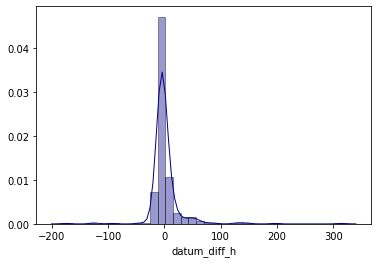

In [66]:
import seaborn as sns
sns.distplot(y_test-y_pred, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

### For which data point do I have a minimal error?

In [67]:
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)

In [68]:
prediction_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

In [69]:
prediction_df.head()

,status,ort,status_code,ort_code,datum_diff_h,0
0,Die Sendung befindet sich auf dem Weg zum Empf...,Krefeld,4,44,4.0,6.383037
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,23,78,2.0,12.541315
2,Die Sendung wurde abgeholt.,Unbekannt,19,78,9.0,16.794468
3,Die Sendung wird fu00FCr die Verladung ins Zus...,Oldenburg MechZB,16,64,16.0,7.189202
4,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,28,36,9.0,14.876673


In [70]:
prediction_df.columns = ['status', 'ort', 'status_code', 'ort_code', 'y', 'y_pred']

In [71]:
prediction_df.head()

,status,ort,status_code,ort_code,y,y_pred
0,Die Sendung befindet sich auf dem Weg zum Empf...,Krefeld,4,44,4.0,6.383037
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,23,78,2.0,12.541315
2,Die Sendung wurde abgeholt.,Unbekannt,19,78,9.0,16.794468
3,Die Sendung wird fu00FCr die Verladung ins Zus...,Oldenburg MechZB,16,64,16.0,7.189202
4,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,28,36,9.0,14.876673


In [72]:
prediction_df["diff"] = abs(prediction_df["y"] - prediction_df["y_pred"])

In [73]:
prediction_df.head()

,status,ort,status_code,ort_code,y,y_pred,diff
0,Die Sendung befindet sich auf dem Weg zum Empf...,Krefeld,4,44,4.0,6.383037,2.383037
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,23,78,2.0,12.541315,10.541315
2,Die Sendung wurde abgeholt.,Unbekannt,19,78,9.0,16.794468,7.794468
3,Die Sendung wird fu00FCr die Verladung ins Zus...,Oldenburg MechZB,16,64,16.0,7.189202,8.810798
4,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,28,36,9.0,14.876673,5.876673


In [74]:
prediction_df[prediction_df["diff"] > 25].values

array([['Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit.',
        'Unbekannt', 14, 78, 0.0, 175.9694027777778, 175.9694027777778],
       ['Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.',
        'Unbekannt', 17, 78, 373.0, 57.23536742159679, 315.7646325784032],
       ['Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.',
        'Unbekannt', 18, 78, 271.0, 142.35790792265598,
        128.64209207734402],
       ['Leider war eine Zustellung der Sendung nicht mu00F6glich. Gru00FCnde hierfu00FCr ku00F6nnen sein: Kein Zugang zum Gebu00E4ude, kein Schild an der Klingel, Empfu00E4nger ggf. verzogen, etc.',
        'Unbekannt', 45, 78, 74.0, 23.469724766292003, 50.530275233708],
       ['Die Sendung wurde direkt ab Paketzentrum dem Geschu00E4ftskunden zug